In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import plot, show, figure
%matplotlib inline

**To organize the data**

In [2]:
col = ["day","mean"]
mp = pd.DataFrame(columns = col)
checkerDuplicates = set()

for year in range(1995, 2019):
    print(year, end=" ")
    if year <= 2015:
        t = pd.read_excel('datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(year)+'.xlsx')
    else:
        t = pd.read_excel('datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(year)+'.xls')
    if year == 2011:
        tmpi = 0
    for i, row in t.iterrows():
        tmpl = []
        if year == 2011:
            if tmpi < 2:
                continue
            else: 
               tmpl = [row[0], np.mean(row[1:-2]), row[-2]]
            tmpi += 1
        else:
            if (i < 2):
                continue
            if year in [1995,1996,1997,1998,1999,2001,2002,2003,2004,2006,2007,2008,2009,]:
                tmpl = [row[0], np.max(np.mean(row[1:]))]
            elif year in [2000,2005,2010,2015,2016,2017,2018]: 
                tmpl = [row[0], np.mean(row[1:-1])]
            else:
                tmpl = [row[0], np.mean(row[1:-2])]
        if tmpl[0] is np.nan:
            continue
        if not isinstance(tmpl[0], str):
            tmpl[0] = "{:%Y-%m-%d}".format(tmpl[0])
            
        if not tmpl[0] in checkerDuplicates:
            mp.loc[len(mp), :] = tmpl
            checkerDuplicates.add(tmpl[0])


1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 

In [3]:
mp.head()

,day,mean
0,1995-07-20,1.40943
1,1995-07-21,4.92433
2,1995-07-22,1.2695
3,1995-07-23,0.953083
4,1995-07-24,4.30592


In [4]:
mp.to_csv('allYearPrices.csv')

In [5]:
mp = pd.read_csv('allYearPrices.csv')

In [6]:
mp.head()

,Unnamed: 0,day,mean
0,0,1995-07-20,1.409435
1,1,1995-07-21,4.924333
2,2,1995-07-22,1.269500
3,3,1995-07-23,0.953083
4,4,1995-07-24,4.305917


**See the historical data**

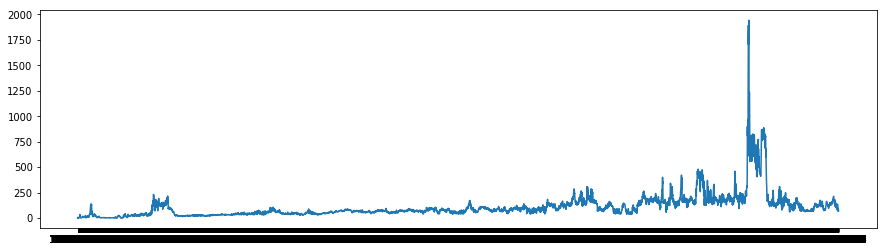

In [7]:
figure(figsize=(15,4))
plot(mp['day'].tolist(), mp['mean'].tolist())
show()

**See the historical data with a logarithmic transformation to see the data in a more friendly way**

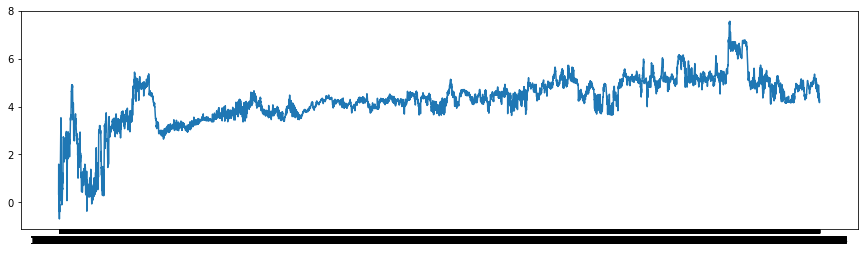

In [8]:
figure(figsize=(15,4))
plot(mp['day'].tolist(), np.log(mp['mean'].tolist()))
show()

In [9]:
import tensorflow as tf
tf.enable_eager_execution()

C:\Users\Larry\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
class Model(object):
    def __init__(self, L):
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

Learning rate: 0.005


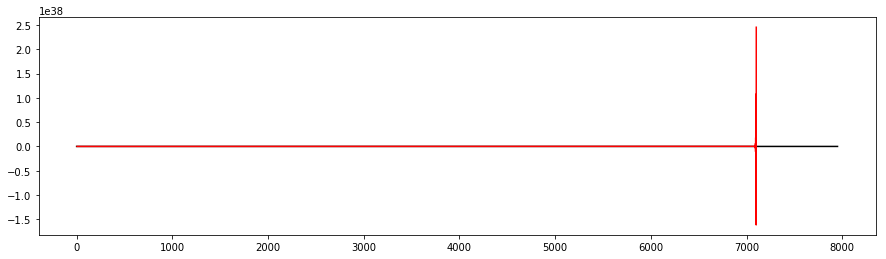

Learning rate: 0.005


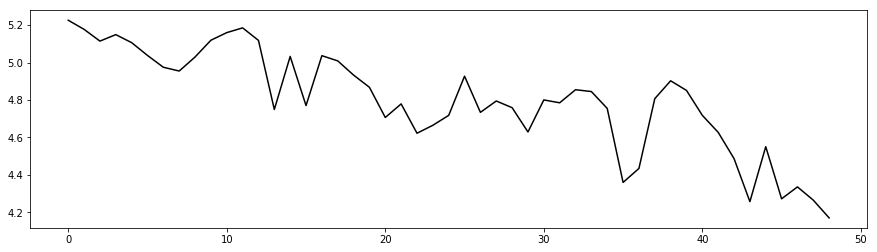

Learning rate: 0.0005


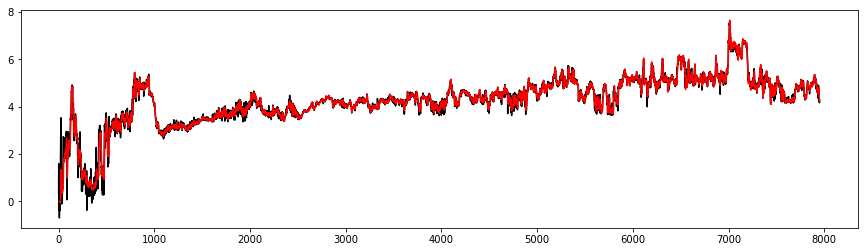

Learning rate: 0.0005


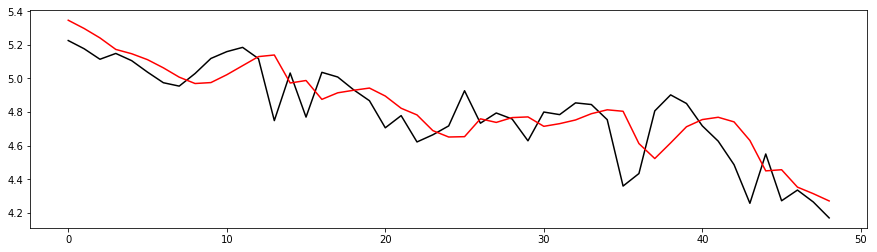

Learning rate: 5e-05


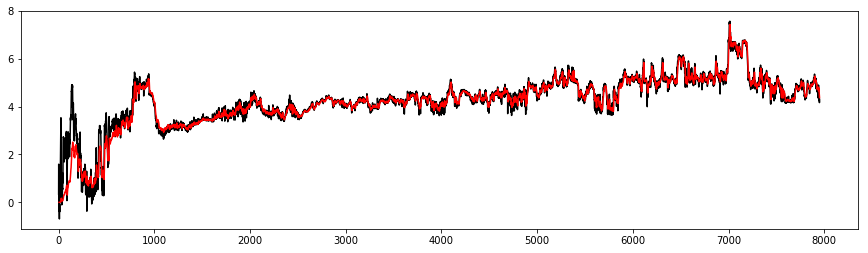

Learning rate: 5e-05


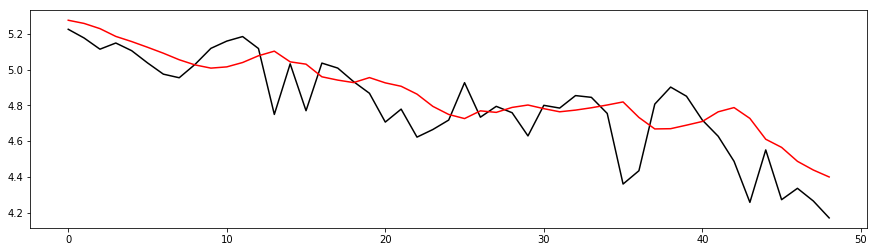

In [11]:
for learning_rate in [0.005, 0.0005, 0.00005]:
    ##
    ##  Para pronosticar el valor actual se toman los `L`
    ##  valores previos de la serie
    ##
    L = 5

    ##
    ##  Modelo
    ##
    model = Model(L)
    d = np.log(mp['mean'])
    ##
    ##  Pronosticos del modelo
    ##
    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=learning_rate, x=x, y_desired=d[t])
    
    print("Learning rate:", learning_rate)
    figure(figsize=(15,4))
    plot(d, color='black');
    plot(y_pred, color = 'red');
    show()
    print("Learning rate:", learning_rate)
    figure(figsize=(15,4))
    plot(d[-50:-1].tolist(), color='black');
    plot(y_pred[-50:-1], color = 'red');
    show()

As we can see, Learning rate: 0.0005 is the most accurate number. 

Now, we should use exp to invert the logarithm.

Learning rate: 5e-05


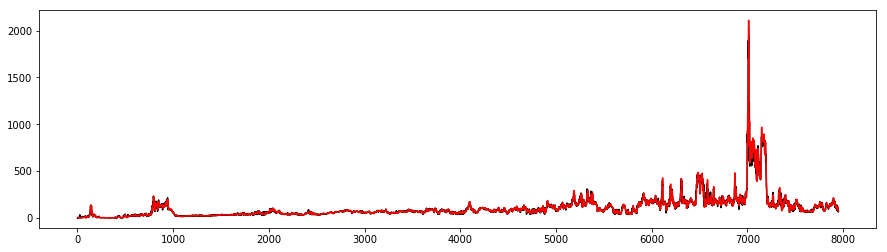

Learning rate: 5e-05


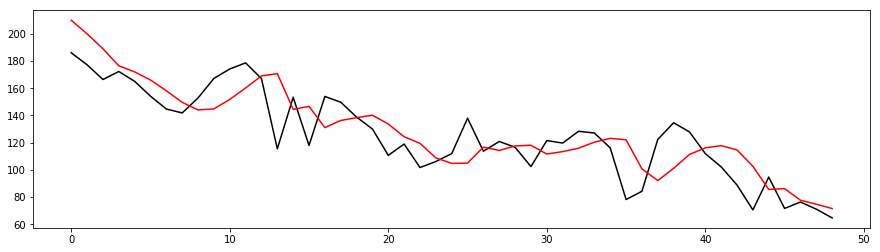

In [12]:
##
##  Para pronosticar el valor actual se toman los `L`
##  valores previos de la serie
##
L = 5

##
##  Modelo
##
model = Model(L)
d = np.log(mp['mean'])
##
##  Pronosticos del modelo
##
y_pred = np.empty(len(d))
y_pred[:] = np.nan

for t in range(L, len(d)):
    x = d[t-L:t]
    y_pred[t] = model(x)
    model.fit(mu=0.0005, x=x, y_desired=d[t])

d = np.exp(d)
y_pred = np.exp(y_pred)

print("Learning rate:", learning_rate)
figure(figsize=(15,4))
plot(d, color='black');
plot(y_pred, color = 'red');
show()
print("Learning rate:", learning_rate)
figure(figsize=(15,4))
plot(d[-50:-1].tolist(), color='black');
plot(y_pred[-50:-1], color = 'red');
show()